In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -qq ./drive/My\ Drive/Colab\ Notebooks/data/twitter_sentiment.zip

In [3]:
import csv
import numpy as np
import torch
import torch.nn as nn
try:
    import emoji
except ModuleNotFoundError:
    !pip install emoji
    import emoji
try:
    from transformers import AutoTokenizer, AutoModel
except ModuleNotFoundError:
    !pip install transformers
    from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False, normalization=True)
max_leng = 50
freq = [0, 0, 0]

     |████████████████████████████████| 51kB 5.7MB/s 
  Created wheel for emoji: filename=emoji-0.6.0-cp36-none-any.whl size=49717 sha256=6589ebe7ef69e833996b864fff9db8243881002f888c8d0a52fb6801e55324da
  Stored in directory: /root/.cache/pip/wheels/46/2c/8b/9dcf5216ca68e14e0320e283692dce8ae321cdc01e73e17796
Successfully built emoji
     |████████████████████████████████| 1.5MB 16.8MB/s 
     |████████████████████████████████| 2.9MB 51.4MB/s 
     |████████████████████████████████| 890kB 47.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=7f7c2e98b560defd3e61cbba3ed3b347f5f933fbde03f19af53b3951d29b41c2
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


In [6]:
class Twitter_data(torch.utils.data.Dataset):
    def __init__(self, csv_filename, mode='train', transform=None):
        self.mode, self.transform = mode, transform
        self.comments = []
        self.labels = []
        global max_leng
        
        with open(csv_filename, newline='') as f:
            reader = csv.DictReader(f)
            name = reader.fieldnames
            for row in reader:
#                 if len(row[name[0]]) > max_leng:
#                     max_leng = len(row[name[0]])
                if mode != 'test':
                    self.comments.append(row[name[0]])
                    freq[int(row[name[1]])] += 1
                    self.labels.append(row[name[1]])
                else:
                    self.comments.append(row[name[1]])
    def __getitem__(self, index):
        global max_leng
        comment = self.comments[index]
        encoding = [tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            max_length=max_leng,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True,
            return_token_type_ids=False,
        )]
        encoding = encoding[0]
        if self.mode == 'test':
            return {
                'comment': self.comments[index].lower(),
                'ids': encoding['input_ids'].flatten(),
                'att_mask': encoding['attention_mask'].flatten()
            }
        return {
            'comment': self.comments[index].lower(),
            'ids': encoding['input_ids'].flatten(),
            'att_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(int(self.labels[index]))
        }
    def __len__(self):
        return len(self.comments)

In [8]:
dataset_train = Twitter_data('./twitter_sentiment/train.csv', mode='train', transform='yes')
dataset_val = Twitter_data('./twitter_sentiment/val.csv', mode='train')
dataset_test = Twitter_data('./twitter_sentiment/test.csv', mode='test')
print('The first comment:', dataset_train[0]['comment'])
print('Ids of the first comment:', dataset_train[0]['ids'])
print('Sentiment label of first comment:', dataset_train[0]['label'])
# print('Length of the longest comment:', max_leng)
print('Class distribution:', freq)
weight = max(freq)/torch.tensor(freq)
weight = weight.cuda()
print('Weight:', weight)

The first comment: @southwestair what's up with the wait times on your customer service line? tried 2x on fri. and now i've been on for over 15 min.
Ids of the first comment: tensor([    0,     5,   165,    20,    49,    30,     6,   257,   426,    24,
           44,  3422,  1027,   651,    21,  9729, 31075,    24,  9048,     4,
           13,    77,     8,   120,   108,    24,    19,   141,   532,  1695,
            4,     2,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1])
Sentiment label of first comment: tensor(0)
Class distribution: [7342, 2479, 1891]
Weight: tensor([1.0000, 2.9617, 3.8826], device='cuda:0')


In [9]:
from torch.utils.data import DataLoader
BATCH_SIZE = 256
train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
class Sentiment_classifier(nn.Module):
    def __init__(self):
        super(Sentiment_classifier, self).__init__()
        self.embedding = AutoModel.from_pretrained("vinai/bertweet-base")
        self.fc = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(self.embedding.config.hidden_size, 3)
        )
    def forward(self, x, mask):
        _, cls = self.embedding(x, attention_mask=mask, return_dict=False)
        out = self.fc(cls)
        return out
model = Sentiment_classifier().cuda()

In [11]:
criterion = nn.CrossEntropyLoss(weight=weight)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

In [12]:
def train(input_data, model, criterion, optimizer):
    model.train()
    loss_list = []
    total_count = 0
    acc_count = 0
    for data in input_data:
        comments, labels, masks = data['ids'].cuda(), data['label'].cuda(), data['att_mask'].cuda()
        optimizer.zero_grad()
        out = model(comments, masks)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(out, 1)
        total_count += out.shape[0]
        acc_count += (predicted == labels).sum().item()
        loss_list.append(loss.item())
        
    acc = acc_count/total_count
    loss = sum(loss_list)/len(loss_list)
    return acc, loss

In [13]:
def val(input_data, model, criterion):
    model.eval()
    loss_list = []
    total_count = 0
    acc_count = 0
    with torch.no_grad():
        for data in input_data:
            comments, labels, masks = data['ids'].cuda(), data['label'].cuda(), data['att_mask'].cuda()
            optimizer.zero_grad()
            out = model(comments, masks)
            loss = criterion(out, labels)

            _, predicted = torch.max(out, 1)
            total_count += out.shape[0]
            acc_count += (predicted == labels).sum().item()
            loss_list.append(loss.item())
        
    acc = acc_count/total_count
    loss = sum(loss_list)/len(loss_list)
    return acc, loss

In [14]:
max_epochs = 10
log_interval = 1

train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []

patience = 0
patience_lr = 0
max_acc = 0
best_model = None
# torch.load('model_params.pth')
# model.load_state_dict(best_model)

print("Start training...")
for epoch in range(1, max_epochs+1):
    train_acc, train_loss = train(train_loader, model, criterion, optimizer)
    val_acc, val_loss = val(val_loader, model, criterion)
    
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)
    patience += 1
    patience_lr += 1
    
    if val_acc > max_acc:
        patience = 0
        patience_lr = 0
        max_acc = val_acc
        best_model = model.state_dict()
    
    if epoch % log_interval == 0:
        print('')
        print('=' * 20, 'Epoch', epoch, '=' * 20)
        print('Train Acc: {:.6f} Train Loss: {:.6f}'.format(train_acc, train_loss))
        print('  Val Acc: {:.6f}   Val Loss: {:.6f}'.format(val_acc, val_loss))
        
    if patience > 10: #early stopping
        print('Early Stopping')
        break
            
    if patience_lr > 5: #step lr
        patience_lr = 0
        print('Decreasing lr')
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1
            
torch.save(best_model, 'model_params.pth')

Start training...

==================== Epoch 1 ====================
Train Acc: 0.685402 Train Loss: 0.944757
  Val Acc: 0.802596   Val Loss: 0.644138

==================== Epoch 2 ====================
Train Acc: 0.827283 Train Loss: 0.542210
  Val Acc: 0.850410   Val Loss: 0.466843

==================== Epoch 3 ====================
Train Acc: 0.851971 Train Loss: 0.422085
  Val Acc: 0.842896   Val Loss: 0.449232

==================== Epoch 4 ====================
Train Acc: 0.870706 Train Loss: 0.376716
  Val Acc: 0.844262   Val Loss: 0.456355

==================== Epoch 5 ====================
Train Acc: 0.883197 Train Loss: 0.332808
  Val Acc: 0.840847   Val Loss: 0.472770

==================== Epoch 6 ====================
Train Acc: 0.895785 Train Loss: 0.303239
  Val Acc: 0.827186   Val Loss: 0.483731

==================== Epoch 7 ====================
Train Acc: 0.895004 Train Loss: 0.288204
  Val Acc: 0.859973   Val Loss: 0.524515

==================== Epoch 8 ====================


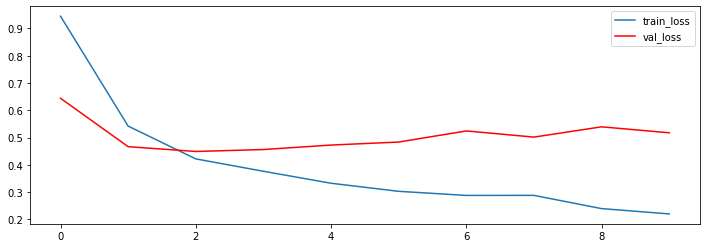

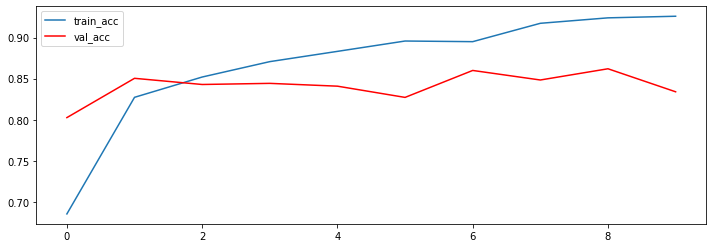

In [15]:
import matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(range(len(train_loss_list)), train_loss_list)
plt.plot(range(len(val_loss_list)), val_loss_list, c='r')
plt.legend(['train_loss', 'val_loss'])
plt.show()
plt.figure(figsize=(12, 4))
plt.plot(range(len(train_acc_list)), train_acc_list)
plt.plot(range(len(val_acc_list)), val_acc_list, c='r')
plt.legend(['train_acc', 'val_acc'])
plt.show()

In [16]:
def inference(input_data, model):
    model.eval()
    output_list = []
    with torch.no_grad():
        for data in input_data:
            comments, masks = data['ids'].cuda(), data['att_mask'].cuda()
            out = model(comments, masks)

            _, predicted = torch.max(out, 1)
            output_list.extend(predicted.to('cpu').numpy().tolist())
        
    return output_list

In [17]:
model.load_state_dict(torch.load('model_params.pth'))
idx = 0
output_csv = inference(test_loader, model)
with open('result.csv', 'w', newline='') as csvFile:
    writer = csv.DictWriter(csvFile, fieldnames=['index', 'sentiment_label'])
    writer.writeheader()
    for result in output_csv:
        writer.writerow({'index':idx, 'sentiment_label':result})
        idx+=1